In [36]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np
import os

%matplotlib inline
sns.set(style="whitegrid")

In [3]:
# Download current premier league table

team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values
  

team_df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
team_df.columns = cols
team_df = team_df.sort_values('Pos')
team_df['team'] = team_df.index
team_df = team_df[['team']+cols]
team_df.head(5)


,team,Pos,P_ov,W_ov,D_ov,L_ov,F_ov,A_ov,W_hm,D_hm,L_hm,F_hm,A_hm,W_aw,D_aw,L_aw,F_aw,A_aw,GD,PTS
Manchester City,Manchester City,1,22,20,2,0,64,13,10,1,0,39,8,10,1,0,25,5,51,62
Manchester United,Manchester United,2,22,14,5,3,45,16,8,2,1,24,5,6,3,2,21,11,29,47
Chelsea,Chelsea,3,22,14,4,4,41,16,8,1,2,21,7,6,3,2,20,9,25,46
Liverpool,Liverpool,4,22,12,8,2,50,25,6,5,0,21,4,6,3,2,29,21,25,44
Tottenham Hotspur,Tottenham Hotspur,5,21,12,4,5,41,20,6,3,1,21,8,6,1,4,20,12,21,40


In [4]:
# Download players

import numpy as np

url = "https://fantasy.premierleague.com/drf/bootstrap-static"
r  = requests.get(url)
data = json.loads(r.text)
all_players = data['elements']

player_dict = {}
position_dict = {}
cost_dict = {}
status_dict = {}

for i in all_players:
    player_dict[i['id']] = i['web_name']
    position_dict[i['id']] = i['element_type']
    cost_dict[i['id']] = i['now_cost']
    status_dict[i['id']] = i['status']
    

# Download player history
history_dict = {};
current_dict = {};
for i in player_dict: 
    url = "https://fantasy.premierleague.com/drf/element-summary/" + str(i)
    r  = requests.get(url)
    data = json.loads(r.text)
    # data['fixtures']
    history = data['history']
    history_past = data['history_past']
   
    # Dataset with total_points per historic season and calculated average points per season
    points_seasons = np.zeros((12,), dtype=np.int)
    for season in history_past:
        points_seasons[season['season']] = int(season['total_points']) 
   
    history_dict[i] = points_seasons
    
        

    # Dataset with points for current season
    points_this = np.zeros((22,), dtype=np.int)
    for game in history:
        points_this[int(game['round'])-1] = int(game['total_points'])
    
    current_dict[i] = points_this
    

print("Player data downloaded..")
        

Player data downloaded..


In [5]:
df = pd.DataFrame.from_dict(history_dict, orient='index')
cols = ['2005/06', '2006/07', '2007/08', '2008/09', '2009/10', '2010/11',
           '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17']
df.columns = cols
df.insert(0, 'Name', player_dict.values())
df.insert(1, 'Position', position_dict.values())
df.insert(2, "Cost", cost_dict.values())
df.insert(3, "Status", status_dict.values())
df = df.replace(0, np.NaN)
df2 = df[['2015/16','2016/17']]
df['avg2yr'] = df2.mean(axis=1)
df['cost-pt'] = df['Cost']/df['avg2yr']
df = df.sort_values('2016/17', axis=0, ascending=False)
df.drop(['2005/06','2006/07'], axis=1, inplace=True)
df.head(5)

,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
14,Sánchez,3,118,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,167.0,264.0,215.5,0.547564
388,Alli,3,90,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.0,225.0,195.5,0.460358
104,Hazard,3,107,a,NaN,NaN,NaN,NaN,NaN,190.0,202.0,233.0,104.0,224.0,164.0,0.652439
394,Kane,4,129,a,NaN,NaN,NaN,NaN,NaN,5.0,28.0,191.0,211.0,224.0,217.5,0.593103
285,Lukaku,4,113,d,NaN,NaN,NaN,NaN,11.0,159.0,168.0,135.0,185.0,221.0,203.0,0.556650


In [6]:
#Attackers
df_attack = df[df['Position']==4]
df_attack.head(20)


,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
394,Kane,4,129,a,NaN,NaN,NaN,NaN,NaN,5.0,28.0,191.0,211.0,224.0,217.5,0.593103
285,Lukaku,4,113,d,NaN,NaN,NaN,NaN,11.0,159.0,168.0,135.0,185.0,221.0,203.0,0.556650
114,Costa,4,95,u,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,129.0,196.0,162.5,0.584615
235,Firmino,4,91,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0,180.0,167.5,0.543284
51,King,4,70,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,178.0,138.0,0.507246
257,Agüero,4,117,a,NaN,NaN,NaN,NaN,211.0,121.0,156.0,216.0,184.0,175.0,179.5,0.651811
52,Defoe,4,76,i,104.0,113.0,150.0,56.0,92.0,124.0,21.0,61.0,138.0,166.0,152.0,0.500000
523,Ibrahimovic,4,96,i,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,163.0,0.588957
209,Vardy,4,86,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,211.0,161.0,186.0,0.462366
371,Llorente,4,74,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,146.0,0.506849


In [7]:
#Mids
df_mid = df[df['Position'] == 3]
df_mid[df_mid['Name'] == 'Salah']


,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
234,Salah,3,101,d,NaN,NaN,NaN,NaN,NaN,NaN,31.0,3.0,NaN,NaN,NaN,NaN


In [8]:
#Defs
df_def = df[df['Position'] ==2]
df_def.head(10)

,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
98,Cahill,2,62,a,50.0,124.0,88.0,105.0,84.0,94.0,147.0,130.0,53.0,178.0,115.5,0.536797
100,Alonso,2,72,a,NaN,NaN,NaN,7.0,14.0,NaN,52.0,NaN,NaN,177.0,177.0,0.406780
97,Azpilicueta,2,70,a,NaN,NaN,NaN,NaN,NaN,100.0,109.0,132.0,124.0,170.0,147.0,0.476190
379,Walker,2,66,d,NaN,NaN,7.0,51.0,140.0,114.0,103.0,27.0,121.0,142.0,131.5,0.501901
222,Milner,2,61,a,84.0,128.0,184.0,97.0,86.0,96.0,67.0,107.0,123.0,139.0,131.0,0.465649
138,Baines,2,57,i,56.0,128.0,138.0,178.0,134.0,177.0,169.0,139.0,67.0,135.0,101.0,0.564356
34,Daniels,2,47,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,134.0,132.0,0.356061
139,Coleman,2,64,i,NaN,NaN,7.0,116.0,30.0,74.0,180.0,130.0,94.0,133.0,113.5,0.563877
101,David Luiz,2,57,d,NaN,NaN,NaN,56.0,68.0,122.0,53.0,NaN,NaN,132.0,132.0,0.431818
425,McAuley,2,46,a,NaN,NaN,NaN,NaN,110.0,113.0,86.0,89.0,97.0,131.0,114.0,0.403509


In [9]:
#gks

df_gk = df[df['Position']==1]
df_gk.head(10)

,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
74,Heaton,1,47,i,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN,149.0,149.0,0.315436
375,Lloris,1,55,a,NaN,NaN,NaN,NaN,NaN,96.0,141.0,121.0,140.0,143.0,141.5,0.388693
94,Courtois,1,55,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,69.0,141.0,105.0,0.523810
260,de Gea,1,59,a,NaN,NaN,NaN,NaN,134.0,114.0,128.0,138.0,142.0,136.0,139.0,0.424460
306,Forster,1,49,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0,68.0,134.0,101.0,0.485149
2,Cech,1,54,a,120.0,171.0,144.0,158.0,127.0,144.0,146.0,38.0,159.0,134.0,146.5,0.368601
30,Boruc,1,42,a,NaN,NaN,NaN,NaN,NaN,63.0,125.0,NaN,108.0,120.0,114.0,0.368421
350,Fabianski,1,46,a,15.0,20.0,15.0,55.0,NaN,13.0,7.0,151.0,123.0,116.0,119.5,0.384937
397,Gomes,1,45,a,NaN,133.0,148.0,108.0,NaN,NaN,NaN,NaN,157.0,113.0,135.0,0.333333
421,Foster,1,44,a,7.0,9.0,37.0,153.0,140.0,105.0,92.0,98.0,56.0,113.0,84.5,0.520710


In [21]:
import collections
import functools
 
class memoized(object):
    '''Decorator. Caches a function's return value each time it is called.
    If called later with the same arguments, the cached value is returned
    (not reevaluated).
    '''
    def __init__(self, func):
       self.func = func
       self.cache = {}
    def __call__(self, *args):
       if not isinstance(args, collections.Hashable):
          # uncacheable. a list, for instance.
          # better to not cache than blow up.
          return self.func(*args)
       if args in self.cache:
          return self.cache[args]
       else:
          value = self.func(*args)
          self.cache[args] = value
          return value
    def __repr__(self):
       '''Return the function's docstring.'''
       return self.func.__doc__
    def __get__(self, obj, objtype):
       '''Support instance methods.'''
       return functools.partial(self.__call__, obj)

def knapsack(items, maxweight):
    """
    Solve the knapsack problem by finding the most valuable
    subsequence of `items` subject that weighs no more than
    `maxweight`.

    `items` is a sequence of pairs `(value, weight)`, where `value` is
    a number and `weight` is a non-negative integer.

    `maxweight` is a non-negative integer.

    Return a pair whose first element is the sum of values in the most
    valuable subsequence, and whose second element is the subsequence.

    >>> items = [(4, 12), (2, 1), (6, 4), (1, 1), (2, 2)]
    >>> knapsack(items, 15)
    (11, [(2, 1), (6, 4), (1, 1), (2, 2)])
    """

    # Return the value of the most valuable subsequence of the first i
    # elements in items whose weights sum to no more than j.
    @memoized
    def bestvalue(i, j):
        if i == 0: return 0
        value, weight = items[i - 1]
        if weight > j:
            return bestvalue(i - 1, j)
        else:
            return max(bestvalue(i - 1, j),
                       bestvalue(i - 1, j - weight) + value)

    j = maxweight
    result = []
    for i in range(len(items), 0, -1):
        if bestvalue(i, j) != bestvalue(i - 1, j):
            result.append(items[i - 1])
            j -= items[i - 1][1]
    result.reverse()
    print ("Number partial solutions %d" % len(bestvalue.cache))
    return bestvalue(len(items), maxweight), result

In [22]:
# Given a budget, can we pick the 5 best defenders?

def_budget = 45+45+50+55
def_v = df_def['2016/17'].tolist()
def_w = df_def['Cost'].tolist()

knapsack( list(zip(def_v, def_w)), def_budget)

# Darn - knapsack picks only 4 players as the most optimal solution


Number partial solutions 24417


(506.0, [(134.0, 47), (131.0, 46), (129.0, 53), (112.0, 47)])

In [23]:
print(history)

[{'own_goals': 0, 'element': 590, 'recoveries': 0, 'yellow_cards': 0, 'loaned_out': 0, 'ea_index': 0, 'round': 22, 'kickoff_time_formatted': '01 Jan 15:00', 'penalties_saved': 0, 'threat': '0.0', 'selected': 0, 'total_points': 0, 'penalties_missed': 0, 'goals_scored': 0, 'attempted_passes': 0, 'saves': 0, 'creativity': '0.0', 'fixture': 218, 'influence': '0.0', 'big_chances_created': 0, 'clean_sheets': 0, 'assists': 0, 'clearances_blocks_interceptions': 0, 'errors_leading_to_goal': 0, 'offside': 0, 'winning_goals': 0, 'errors_leading_to_goal_attempt': 0, 'id': 12364, 'ict_index': '0.0', 'kickoff_time': '2018-01-01T15:00:00Z', 'dribbles': 0, 'team_h_score': 0, 'fouls': 0, 'transfers_in': 0, 'was_home': True, 'transfers_out': 0, 'transfers_balance': 0, 'loaned_in': 0, 'team_a_score': 1, 'big_chances_missed': 0, 'open_play_crosses': 0, 'goals_conceded': 0, 'target_missed': 0, 'minutes': 0, 'key_passes': 0, 'completed_passes': 0, 'penalties_conceded': 0, 'bps': 0, 'opponent_team': 13, 'tac

In [24]:
from pprint import pprint
pprint(current_dict)

{1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 2: array([ 1,  3,  2,  6, 10,  6,  6,  1,  1,  2,  2,  8,  6,  6,  1,  2,  6,
        6,  3,  1,  1,  2]),
 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 4: array([0, 0, 0, 6, 7, 6, 0, 2, 0, 2, 0, 8, 9, 6, 0, 2, 9, 8, 1, 1, 9, 0]),
 5: array([0, 0, 0, 0, 0, 0, 0, 9, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0]),
 6: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 7: array([ 1,  2,  0,  6,  5,  8, 11,  1,  1,  2,  1,  6,  6,  6,  0,  1,  6,
        7,  4,  1,  2,  8]),
 8: array([0, 0, 0, 1, 6, 1, 1, 2, 2, 1, 2, 0, 1, 5, 6, 2, 6, 1, 1, 6, 6, 1]),
 9: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 10: array([ 1,  2,  0,  7,  9,  7, 15,  1,  7,  2,  0,  5,  6,  6,  1,  2,  8,
        5,  1,  0,  0,  0]),
 11: array([ 1,  0, -1,  0,  0,  0,  6,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  3]),
 12: array([ 

In [25]:
df1 = pd.DataFrame.from_dict(current_dict, orient='index')
cols = list(range(1,23))
df1.columns = cols
df1.insert(0, 'Name', player_dict.values())
df1.insert(1, 'Position', position_dict.values())
df1.insert(2, "Cost", cost_dict.values())
df1.insert(3, "Total_Points", df1[list(range(2,19))].sum(axis=1))
df1.insert(4, "Points_Cost", df1["Total_Points"]/df1["Cost"])
df1.insert(5, "Points_Fixture", df1["Total_Points"]/17)
df1.insert(6, "Status", status_dict.values())
df1 = df1.replace(0, np.NaN)
df1 = df1.sort_values('Points_Cost', axis=0, ascending=False)

df1.head(5)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,13,14,15,16,17,18,19,20,21,22
469,Pope,1,48,82.0,1.708333,4.823529,a,NaN,NaN,NaN,...,2.0,2.0,2.0,6.0,11.0,6.0,2.0,1.0,6.0,2.0
350,Fabianski,1,46,74.0,1.608696,4.352941,a,6.0,1.0,7.0,...,9.0,5.0,1.0,6.0,2.0,9.0,3.0,1.0,3.0,2.0
260,de Gea,1,59,93.0,1.576271,5.470588,a,6.0,6.0,7.0,...,6.0,1.0,8.0,2.0,11.0,3.0,1.0,1.0,7.0,6.0
54,Ryan,1,45,68.0,1.511111,4.000000,a,2.0,1.0,6.0,...,3.0,9.0,NaN,2.0,2.0,11.0,6.0,2.0,6.0,3.0
10,Monreal,2,56,83.0,1.482143,4.882353,i,1.0,2.0,NaN,...,6.0,6.0,1.0,2.0,8.0,5.0,1.0,NaN,NaN,NaN


In [26]:
#Attackers
df1_attack = df1[df1['Position']==4]
df1_attack.head(10)


,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,13,14,15,16,17,18,19,20,21,22
161,Rooney,4,75,82.0,1.093333,4.823529,a,9.0,8.0,1.0,...,NaN,15.0,5.0,8.0,8.0,13.0,NaN,NaN,1.0,1.0
348,Diouf,4,55,58.0,1.054545,3.411765,a,2.0,2.0,NaN,...,2.0,2.0,7.0,2.0,2.0,2.0,1.0,NaN,1.0,1.0
159,Calvert-Lewin,4,55,57.0,1.036364,3.352941,a,5.0,5.0,1.0,...,5.0,2.0,12.0,5.0,1.0,6.0,1.0,2.0,1.0,1.0
374,Abraham,4,56,58.0,1.035714,3.411765,d,2.0,2.0,8.0,...,1.0,NaN,2.0,4.0,1.0,2.0,2.0,1.0,1.0,NaN
187,Depoitre,4,55,55.0,1.000000,3.235294,a,NaN,NaN,NaN,...,2.0,1.0,2.0,1.0,5.0,13.0,9.0,1.0,2.0,1.0
211,Okazaki,4,55,52.0,0.945455,3.058824,a,6.0,7.0,1.0,...,NaN,2.0,1.0,4.0,16.0,1.0,1.0,2.0,1.0,2.0
548,Niasse,4,47,40.0,0.851064,2.352941,a,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,4.0,2.0
373,Ayew,4,50,41.0,0.820000,2.411765,a,2.0,2.0,6.0,...,2.0,2.0,2.0,1.0,2.0,1.0,8.0,2.0,7.0,2.0
71,Murray,4,57,46.0,0.807018,2.705882,a,1.0,2.0,NaN,...,1.0,2.0,6.0,2.0,1.0,NaN,1.0,1.0,2.0,8.0
284,Rashford,4,76,60.0,0.789474,3.529412,a,5.0,2.0,6.0,...,2.0,1.0,1.0,6.0,1.0,4.0,1.0,2.0,2.0,1.0


In [27]:
#Goalies
df1_gk = df1[df1['Position']==1]
df1_gk.head(10)


,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,13,14,15,16,17,18,19,20,21,22
469,Pope,1,48,82.0,1.708333,4.823529,a,NaN,NaN,NaN,...,2.0,2.0,2.0,6.0,11.0,6.0,2.0,1.0,6.0,2.0
350,Fabianski,1,46,74.0,1.608696,4.352941,a,6.0,1.0,7.0,...,9.0,5.0,1.0,6.0,2.0,9.0,3.0,1.0,3.0,2.0
260,de Gea,1,59,93.0,1.576271,5.470588,a,6.0,6.0,7.0,...,6.0,1.0,8.0,2.0,11.0,3.0,1.0,1.0,7.0,6.0
54,Ryan,1,45,68.0,1.511111,4.000000,a,2.0,1.0,6.0,...,3.0,9.0,NaN,2.0,2.0,11.0,6.0,2.0,6.0,3.0
2,Cech,1,54,74.0,1.370370,4.352941,a,1.0,3.0,2.0,...,6.0,6.0,1.0,2.0,6.0,6.0,3.0,1.0,1.0,2.0
29,Begovic,1,45,61.0,1.355556,3.588235,a,3.0,2.0,3.0,...,6.0,1.0,2.0,8.0,2.0,1.0,NaN,1.0,2.0,2.0
94,Courtois,1,55,73.0,1.327273,4.294118,a,1.0,6.0,6.0,...,3.0,6.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,1.0
306,Forster,1,49,65.0,1.326531,3.823529,a,6.0,3.0,11.0,...,2.0,5.0,3.0,3.0,1.0,4.0,2.0,NaN,NaN,NaN
189,Schmeichel,1,50,66.0,1.320000,3.882353,a,2.0,6.0,9.0,...,3.0,2.0,10.0,1.0,3.0,2.0,2.0,-1.0,2.0,6.0
163,Lössl,1,46,59.0,1.282609,3.470588,a,9.0,8.0,6.0,...,2.0,NaN,1.0,6.0,1.0,2.0,3.0,3.0,9.0,1.0


In [28]:
#Defs
df1_def = df1[df1['Position']==2]
df1_def.head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,13,14,15,16,17,18,19,20,21,22
10,Monreal,2,56,83.0,1.482143,4.882353,i,1.0,2.0,NaN,...,6.0,6.0,1.0,2.0,8.0,5.0,1.0,NaN,NaN,NaN
78,Ward,2,48,69.0,1.437500,4.058824,d,7.0,2.0,2.0,...,2.0,2.0,2.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN
79,Tarkowski,2,47,67.0,1.425532,3.941176,a,1.0,2.0,2.0,...,2.0,2.0,2.0,6.0,6.0,6.0,NaN,NaN,NaN,1.0
267,Valencia,2,68,89.0,1.308824,5.235294,i,5.0,6.0,9.0,...,8.0,1.0,8.0,1.0,6.0,7.0,NaN,NaN,NaN,NaN
77,Mee,2,49,62.0,1.265306,3.647059,a,NaN,2.0,2.0,...,2.0,2.0,1.0,NaN,NaN,6.0,1.0,1.0,5.0,1.0
97,Azpilicueta,2,70,88.0,1.257143,5.176471,a,1.0,2.0,9.0,...,3.0,NaN,2.0,2.0,2.0,7.0,6.0,12.0,6.0,1.0
100,Alonso,2,72,90.0,1.250000,5.294118,a,NaN,16.0,6.0,...,2.0,6.0,2.0,NaN,6.0,14.0,6.0,14.0,6.0,7.0
56,Duffy,2,46,57.0,1.239130,3.352941,a,1.0,1.0,9.0,...,1.0,6.0,3.0,1.0,1.0,5.0,NaN,1.0,6.0,1.0
245,Otamendi,2,64,79.0,1.234375,4.647059,a,8.0,2.0,1.0,...,NaN,2.0,11.0,11.0,6.0,1.0,7.0,8.0,8.0,2.0
218,Gomez,2,47,56.0,1.191489,3.294118,a,1.0,6.0,10.0,...,2.0,6.0,NaN,6.0,1.0,6.0,1.0,NaN,2.0,2.0


In [29]:
#Mids
df1_mid = df1[df1['Position']==3]
df1_mid.head(30)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,13,14,15,16,17,18,19,20,21,22
70,Groß,3,59,82.0,1.389831,4.823529,a,2.0,2.0,3.0,...,5.0,3.0,2.0,2.0,1.0,3.0,11.0,1.0,3.0,2.0
41,Surman,3,47,62.0,1.319149,3.647059,a,2.0,2.0,2.0,...,3.0,2.0,7.0,5.0,NaN,2.0,2.0,NaN,NaN,NaN
414,Doucouré,3,53,69.0,1.301887,4.058824,a,9.0,3.0,3.0,...,3.0,7.0,2.0,2.0,2.0,7.0,NaN,5.0,1.0,2.0
501,Richarlison,3,64,81.0,1.265625,4.764706,a,4.0,11.0,3.0,...,6.0,2.0,1.0,2.0,6.0,2.0,2.0,5.0,5.0,2.0
247,Sterling,3,89,112.0,1.258427,6.588235,a,NaN,6.0,4.0,...,13.0,9.0,2.0,2.0,9.0,12.0,13.0,11.0,1.0,9.0
342,Shaqiri,3,60,74.0,1.233333,4.352941,a,2.0,1.0,2.0,...,9.0,2.0,8.0,2.0,3.0,2.0,2.0,2.0,NaN,1.0
234,Salah,3,101,124.0,1.227723,7.294118,d,11.0,1.0,11.0,...,7.0,13.0,5.0,11.0,3.0,8.0,10.0,9.0,14.0,NaN
248,David Silva,3,81,94.0,1.160494,5.529412,a,8.0,2.0,6.0,...,1.0,1.0,9.0,8.0,16.0,NaN,3.0,NaN,NaN,1.0
172,Mooy,3,54,62.0,1.148148,3.647059,a,6.0,10.0,3.0,...,2.0,1.0,2.0,3.0,2.0,15.0,2.0,2.0,3.0,2.0
497,Choupo-Moting,3,54,62.0,1.148148,3.647059,a,1.0,3.0,2.0,...,2.0,2.0,2.0,2.0,1.0,NaN,13.0,2.0,1.0,1.0


In [30]:
# Given a budget, can we pick a set of attackers?
# Damn - this picks 4

fwd_budget = 260
fwd_v = df1_attack['Points_Fixture'].tolist()
fwd_w = df1_attack['Cost'].tolist()

knapsack( list(zip(fwd_v, fwd_w)), fwd_budget)


Number partial solutions 12635


(15.0,
 [(4.823529411764706, 75),
  (3.411764705882353, 55),
  (3.3529411764705883, 55),
  (3.411764705882353, 56)])

In [31]:
mid_budget = 260
mid_v = df1_mid['Total_Points'].tolist()
mid_w = df1_mid['Cost'].tolist()

knapsack( list(zip(mid_v, mid_w)), mid_budget)


Number partial solutions 47033


(337.0, [(82.0, 59), (62.0, 47), (81.0, 64), (112.0, 89)])

In [ ]:
# Brute force

def TimestampMillisec64():
    return int((datetime.datetime.utcnow() - datetime.datetime(1970, 1, 1)).total_seconds() * 1000) 


g = df1_gk.fillna(0)
d = df1_def.fillna(0)
m = df1_mid.fillna(0)
a = df1_attack.fillna(0)

g['PFA6'] = g[list(range(17,23))].sum(axis=1)/6
d['PFA6'] = d[list(range(17,23))].sum(axis=1)/6
m['PFA6'] = m[list(range(17,23))].sum(axis=1)/6
a['PFA6'] = a[list(range(17,23))].sum(axis=1)/6

MAX_NGK = 2
MAX_NDEF = 5
MAX_NMID = 5
MAX_NFWD = 3

# Otamendi, Alonso
HO_DEF = d.loc[[245, 100]]

# Salah, Sterling
HO_MID = m.loc[[234, 247]]

# Kane
HO_FWD = a.loc[[394]]

MAX_EPOCHS = 5000000
MAX_COST = 1015

epoch = 0
max_score = 0
max_tm = df1.sample(n=15)

# Only pick from performing players who are not earmarked as High Ownership (HO)
#df1_gk_f = g[(g['PFA6'] > np.percentile(g['PFA6'],50))].drop(HO_GK.index.values)
df1_gk_f = g[(g['PFA6'] > np.percentile(g['PFA6'],80))]
df1_def_f = d[(d['PFA6'] > np.percentile(d['PFA6'],85))].drop(HO_DEF.index.values)
df1_mid_f = m[(m['PFA6'] > np.percentile(m['PFA6'],85))].drop(HO_MID.index.values)
df1_fwd_f = a[(a['PFA6'] > np.percentile(a['PFA6'],90))].drop(HO_FWD.index.values)

t1 = TimestampMillisec64()
while (epoch < MAX_EPOCHS):
    epoch = epoch + 1
    if epoch%10000 == 0:
        t2 = TimestampMillisec64()
        print("Time %d, Epoch %d .." % (round((t2-t1)/1000), epoch))
        t1 = t2
    
    # Pick GKs
    gks = df1_gk_f.sample(n=(MAX_NGK))
                              
    # Pick DEFS
    dfs = df1_def_f.sample(n=(MAX_NDEF - len(HO_DEF)))
    dfs = dfs.append(HO_DEF)
                                   
    # Pick MIDS
    mds = df1_mid_f.sample(n=(MAX_NMID - len(HO_MID)))
    mds = mds.append(HO_MID)
  
    # Pick FWDS
    mfw = df1_fwd_f.sample(n=(MAX_NFWD - len(HO_FWD)))
    mfw = mfw.append(HO_FWD)
                             
                                           
    tm_cost = (gks.sum(axis=0)['Cost']
                + dfs.sum(axis=0)['Cost']
                + mds.sum(axis=0)['Cost']
                + mfw.sum(axis=0)['Cost'])
                              
    tm_score = (gks.sum(axis=0)['Points_Fixture']
                + dfs.sum(axis=0)['Points_Fixture']
                + mds.sum(axis=0)['Points_Fixture']
                + mfw.sum(axis=0)['Points_Fixture'])
        
    if ( (tm_cost > MAX_COST) or (tm_score < 65)):
        continue
    else:
        if (tm_score > max_score):
            max_score = tm_score
            max_tm = gks.append(dfs).append(mds).append(mfw)
            fname = os.path.join('output', 'Team_Bal_%d_PFA6_%d.csv' % (max_score, TimestampMillisec64()))
            max_tm.to_csv(path_or_buf=fname)
            print("Epoch: %d, PFA6: %d, Cost: %d" % (epoch, tm_score, tm_cost))
                

Epoch: 1503, PFA6: 66, Cost: 1007
Time 59, Epoch 10000 ..
Epoch: 15681, PFA6: 66, Cost: 1008
Epoch: 15696, PFA6: 66, Cost: 1013
Epoch: 17108, PFA6: 66, Cost: 1007
Time 59, Epoch 20000 ..
Time 59, Epoch 30000 ..
Time 59, Epoch 40000 ..
Epoch: 40263, PFA6: 67, Cost: 1011
Epoch: 44390, PFA6: 67, Cost: 1014
Time 59, Epoch 50000 ..
Epoch: 54796, PFA6: 68, Cost: 1012
Time 59, Epoch 60000 ..
Time 59, Epoch 70000 ..
Time 59, Epoch 80000 ..
Time 59, Epoch 90000 ..
Time 59, Epoch 100000 ..
Epoch: 101963, PFA6: 68, Cost: 1014
Time 59, Epoch 110000 ..
Time 60, Epoch 120000 ..
Time 60, Epoch 130000 ..
Time 60, Epoch 140000 ..
Time 59, Epoch 150000 ..
Time 59, Epoch 160000 ..
Time 59, Epoch 170000 ..
Time 59, Epoch 180000 ..
Time 59, Epoch 190000 ..
Time 59, Epoch 200000 ..
Time 59, Epoch 210000 ..
Time 59, Epoch 220000 ..
Time 59, Epoch 230000 ..
Time 60, Epoch 240000 ..
Time 59, Epoch 250000 ..
Time 59, Epoch 260000 ..
Time 59, Epoch 270000 ..
Time 59, Epoch 280000 ..
Time 59, Epoch 290000 ..
Time

In [124]:
max_tm.sort_values(['Position', 'PFA6', 'Cost'], axis=0, ascending=False)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
394,Kane,4,129,96.0,0.744186,5.647059,a,1.0,1.0,2.0,...,6.0,2.0,12.0,2.0,1.0,17.0,17.0,0.0,0.0,6.166667
187,Depoitre,4,55,55.0,1.000000,3.235294,a,0.0,0.0,0.0,...,1.0,2.0,1.0,5.0,13.0,9.0,1.0,2.0,1.0,5.166667
211,Okazaki,4,55,52.0,0.945455,3.058824,a,6.0,7.0,1.0,...,2.0,1.0,4.0,16.0,1.0,1.0,2.0,1.0,2.0,3.833333
247,Sterling,3,89,112.0,1.258427,6.588235,a,0.0,6.0,4.0,...,9.0,2.0,2.0,9.0,12.0,13.0,11.0,1.0,9.0,9.166667
234,Salah,3,101,124.0,1.227723,7.294118,d,11.0,1.0,11.0,...,13.0,5.0,11.0,3.0,8.0,10.0,9.0,14.0,0.0,7.333333
106,Willian,3,67,53.0,0.791045,3.117647,a,6.0,3.0,3.0,...,3.0,1.0,1.0,16.0,3.0,3.0,1.0,17.0,1.0,6.833333
172,Mooy,3,54,62.0,1.148148,3.647059,a,6.0,10.0,3.0,...,1.0,2.0,3.0,2.0,15.0,2.0,2.0,3.0,2.0,4.333333
300,Atsu,3,48,39.0,0.812500,2.294118,a,2.0,2.0,6.0,...,0.0,0.0,1.0,2.0,1.0,15.0,1.0,3.0,3.0,4.166667
100,Alonso,2,72,90.0,1.250000,5.294118,a,0.0,16.0,6.0,...,6.0,2.0,0.0,6.0,14.0,6.0,14.0,6.0,7.0,8.833333
97,Azpilicueta,2,70,88.0,1.257143,5.176471,a,1.0,2.0,9.0,...,0.0,2.0,2.0,2.0,7.0,6.0,12.0,6.0,1.0,5.666667


In [39]:
max_tm[max_tm['Position']==1]

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
260,de Gea,1,59,93.0,1.576271,5.470588,a,6.0,6.0,7.0,...,1.0,8.0,2.0,11.0,3.0,1.0,1.0,7.0,6.0,4.833333
94,Courtois,1,55,73.0,1.327273,4.294118,a,1.0,6.0,6.0,...,6.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,1.0,4.500000


In [40]:
max_tm[max_tm['Position']==2]

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
100,Alonso,2,72,90.0,1.250000,5.294118,a,0.0,16.0,6.0,...,6.0,2.0,0.0,6.0,14.0,6.0,14.0,6.0,7.0,8.833333
245,Otamendi,2,64,79.0,1.234375,4.647059,a,8.0,2.0,1.0,...,2.0,11.0,11.0,6.0,1.0,7.0,8.0,8.0,2.0,5.333333
245,Otamendi,2,64,79.0,1.234375,4.647059,a,8.0,2.0,1.0,...,2.0,11.0,11.0,6.0,1.0,7.0,8.0,8.0,2.0,5.333333


In [41]:
max_tm[max_tm['Position']==3]

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
200,Albrighton,3,55,47.0,0.854545,2.764706,a,5.0,3.0,1.0,...,8.0,3.0,5.0,1.0,2.0,4.0,8.0,2.0,13.0,5.0
199,Mahrez,3,86,89.0,1.034884,5.235294,a,5.0,11.0,2.0,...,9.0,6.0,9.0,8.0,2.0,5.0,8.0,5.0,14.0,7.0
497,Choupo-Moting,3,54,62.0,1.148148,3.647059,a,1.0,3.0,2.0,...,2.0,2.0,2.0,1.0,0.0,13.0,2.0,1.0,1.0,3.0


In [42]:
max_tm[max_tm['Position']==4]

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
257,Agüero,4,117,77.0,0.65812,4.529412,a,9.0,2.0,1.0,...,2.0,2.0,0.0,6.0,1.0,16.0,2.0,1.0,6.0,5.333333
187,Depoitre,4,55,55.0,1.00000,3.235294,a,0.0,0.0,0.0,...,1.0,2.0,1.0,5.0,13.0,9.0,1.0,2.0,1.0,5.166667


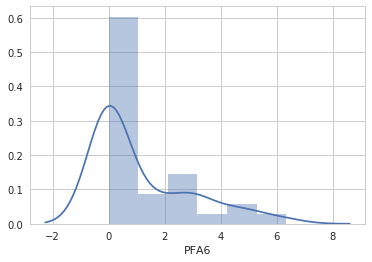

In [102]:
sns.distplot(g['PFA6'])

In [112]:
np.percentile(g['PFA6'],80)

2.8333333333333335

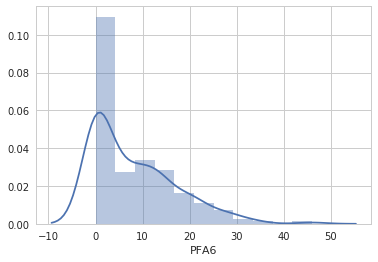

In [124]:
sns.distplot(d['PFA6'])

In [105]:
np.percentile(d['PFA6'],95)

4.4083333333333314

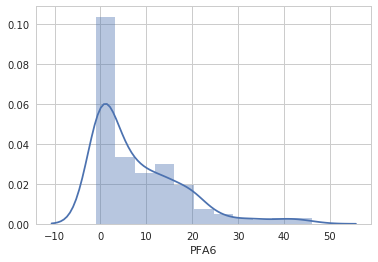

In [126]:
sns.distplot(m['PFA6'])

In [107]:
np.percentile(m['PFA6'],95)

4.4166666666666661

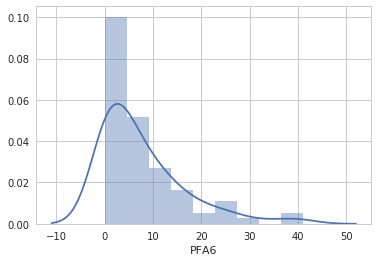

In [128]:
sns.distplot(a['PFA6'])

In [110]:
np.percentile(a['PFA6'],95)

4.333333333333333

In [115]:
gks

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
350,Fabianski,1,46,74.0,1.608696,4.352941,a,6.0,1.0,7.0,...,5.0,1.0,6.0,2.0,9.0,3.0,1.0,3.0,2.0,3.333333
163,Lössl,1,46,59.0,1.282609,3.470588,a,9.0,8.0,6.0,...,0.0,1.0,6.0,1.0,2.0,3.0,3.0,9.0,1.0,3.166667


In [116]:
dfs

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
475,Robertson,2,47,30.0,0.638298,1.764706,a,0.0,9.0,0.0,...,0.0,2.0,2.0,6.0,9.0,1.0,6.0,1.0,0.0,3.833333
7,Bellerín,2,60,69.0,1.150000,4.058824,a,1.0,2.0,0.0,...,6.0,0.0,1.0,6.0,7.0,4.0,1.0,2.0,8.0,4.666667
97,Azpilicueta,2,70,88.0,1.257143,5.176471,a,1.0,2.0,9.0,...,0.0,2.0,2.0,2.0,7.0,6.0,12.0,6.0,1.0,5.666667
245,Otamendi,2,64,79.0,1.234375,4.647059,a,8.0,2.0,1.0,...,2.0,11.0,11.0,6.0,1.0,7.0,8.0,8.0,2.0,5.333333
100,Alonso,2,72,90.0,1.250000,5.294118,a,0.0,16.0,6.0,...,6.0,2.0,0.0,6.0,14.0,6.0,14.0,6.0,7.0,8.833333


In [118]:
mfw

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
187,Depoitre,4,55,55.0,1.000000,3.235294,a,0.0,0.0,0.0,...,1.0,2.0,1.0,5.0,13.0,9.0,1.0,2.0,1.0,5.166667
211,Okazaki,4,55,52.0,0.945455,3.058824,a,6.0,7.0,1.0,...,2.0,1.0,4.0,16.0,1.0,1.0,2.0,1.0,2.0,3.833333
394,Kane,4,129,96.0,0.744186,5.647059,a,1.0,1.0,2.0,...,6.0,2.0,12.0,2.0,1.0,17.0,17.0,0.0,0.0,6.166667


In [119]:
mds

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,14,15,16,17,18,19,20,21,22,PFA6
14,Sánchez,3,118,68.0,0.576271,4.000000,a,0.0,0.0,2.0,...,8.0,1.0,5.0,3.0,3.0,7.0,15.0,5.0,2.0,5.833333
340,Arnautovic,3,70,30.0,0.428571,1.764706,a,2.0,-2.0,0.0,...,2.0,1.0,7.0,3.0,9.0,7.0,15.0,0.0,0.0,5.666667
388,Alli,3,90,61.0,0.677778,3.588235,a,8.0,2.0,9.0,...,2.0,2.0,6.0,1.0,1.0,8.0,15.0,0.0,0.0,4.166667
234,Salah,3,101,124.0,1.227723,7.294118,d,11.0,1.0,11.0,...,13.0,5.0,11.0,3.0,8.0,10.0,9.0,14.0,0.0,7.333333
247,Sterling,3,89,112.0,1.258427,6.588235,a,0.0,6.0,4.0,...,9.0,2.0,2.0,9.0,12.0,13.0,11.0,1.0,9.0,9.166667


Index([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22],
      dtype='object')

In [120]:
g['VAR'] = g.iloc[:, 8:29].var(axis=1)
g['PperVAR'] = g['PFA6']/g['VAR']
g.sort_values(['PFA6', 'VAR', 'Cost'], ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,PFA6,VAR,PperVAR
240,Ederson,1,55,61.0,1.109091,3.588235,a,6.0,2.0,2.0,...,3.0,7.0,2.0,6.0,6.0,14.0,3.0,6.333333,9.814286,0.645318
135,Pickford,1,49,59.0,1.204082,3.470588,a,6.0,4.0,2.0,...,2.0,10.0,2.0,9.0,10.0,2.0,2.0,5.833333,14.190476,0.411074
54,Ryan,1,45,68.0,1.511111,4.000000,a,2.0,1.0,6.0,...,2.0,2.0,11.0,6.0,2.0,6.0,3.0,5.000000,9.047619,0.552632
260,de Gea,1,59,93.0,1.576271,5.470588,a,6.0,6.0,7.0,...,2.0,11.0,3.0,1.0,1.0,7.0,6.0,4.833333,9.628571,0.501978
469,Pope,1,48,82.0,1.708333,4.823529,a,0.0,0.0,0.0,...,6.0,11.0,6.0,2.0,1.0,6.0,2.0,4.666667,10.457143,0.446266
94,Courtois,1,55,73.0,1.327273,4.294118,a,1.0,6.0,6.0,...,2.0,2.0,6.0,6.0,6.0,6.0,1.0,4.500000,4.247619,1.059417
421,Foster,1,44,48.0,1.090909,2.823529,a,7.0,6.0,2.0,...,2.0,10.0,1.0,1.0,8.0,3.0,2.0,4.166667,6.647619,0.626791
350,Fabianski,1,46,74.0,1.608696,4.352941,a,6.0,1.0,7.0,...,6.0,2.0,9.0,3.0,1.0,3.0,2.0,3.333333,8.847619,0.376749
163,Lössl,1,46,59.0,1.282609,3.470588,a,9.0,8.0,6.0,...,6.0,1.0,2.0,3.0,3.0,9.0,1.0,3.166667,9.357143,0.338422
2,Cech,1,54,74.0,1.370370,4.352941,a,1.0,3.0,2.0,...,2.0,6.0,6.0,3.0,1.0,1.0,2.0,3.166667,7.328571,0.432099


In [121]:
d['VAR'] = d.iloc[:, 8:29].var(axis=1)
d['PperVAR'] = d['PFA6']/d['VAR']
d.sort_values(['PFA6', 'VAR', 'Cost'], ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,PFA6,VAR,PperVAR
100,Alonso,2,72,90.0,1.250000,5.294118,a,0.0,16.0,6.0,...,0.0,6.0,14.0,6.0,14.0,6.0,7.0,8.833333,23.928571,0.369154
97,Azpilicueta,2,70,88.0,1.257143,5.176471,a,1.0,2.0,9.0,...,2.0,2.0,7.0,6.0,12.0,6.0,1.0,5.666667,17.147619,0.330464
220,Klavan,2,44,42.0,0.954545,2.470588,a,0.0,7.0,0.0,...,2.0,9.0,6.0,1.0,6.0,1.0,11.0,5.666667,11.790476,0.480614
245,Otamendi,2,64,79.0,1.234375,4.647059,a,8.0,2.0,1.0,...,11.0,6.0,1.0,7.0,8.0,8.0,2.0,5.333333,20.547619,0.259560
215,Lovren,2,53,49.0,0.924528,2.882353,a,1.0,1.0,5.0,...,1.0,6.0,13.0,1.0,0.0,2.0,7.0,4.833333,11.961905,0.404061
483,Danilo,2,50,26.0,0.520000,1.529412,a,6.0,1.0,5.0,...,0.0,7.0,0.0,7.0,8.0,6.0,1.0,4.833333,8.914286,0.542201
103,Rüdiger,2,58,49.0,0.844828,2.882353,a,0.0,1.0,6.0,...,0.0,2.0,0.0,6.0,6.0,14.0,0.0,4.666667,20.457143,0.228119
4,Koscielny,2,60,65.0,1.083333,3.823529,d,0.0,0.0,0.0,...,2.0,9.0,8.0,1.0,1.0,9.0,0.0,4.666667,13.347619,0.349625
7,Bellerín,2,60,69.0,1.150000,4.058824,a,1.0,2.0,0.0,...,1.0,6.0,7.0,4.0,1.0,2.0,8.0,4.666667,10.000000,0.466667
264,Jones,2,57,63.0,1.105263,3.705882,a,6.0,6.0,7.0,...,0.0,8.0,2.0,1.0,1.0,9.0,6.0,4.500000,12.661905,0.355397


In [122]:
m['VAR'] = m.iloc[:, 8:29].var(axis=1)
m['PperVAR'] = m['PFA6']/m['VAR']
m.sort_values(['PFA6', 'VAR', 'Cost'], ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,PFA6,VAR,PperVAR
247,Sterling,3,89,112.0,1.258427,6.588235,a,0.0,6.0,4.0,...,2.0,9.0,12.0,13.0,11.0,1.0,9.0,9.166667,22.947619,0.399460
234,Salah,3,101,124.0,1.227723,7.294118,d,11.0,1.0,11.0,...,11.0,3.0,8.0,10.0,9.0,14.0,0.0,7.333333,23.561905,0.311237
252,De Bruyne,3,102,110.0,1.078431,6.470588,a,3.0,2.0,3.0,...,2.0,10.0,10.0,3.0,6.0,3.0,12.0,7.333333,14.047619,0.522034
199,Mahrez,3,86,89.0,1.034884,5.235294,a,5.0,11.0,2.0,...,9.0,8.0,2.0,5.0,8.0,5.0,14.0,7.000000,13.690476,0.511304
279,Lingard,3,62,57.0,0.919355,3.352941,a,1.0,0.0,4.0,...,2.0,3.0,10.0,5.0,13.0,2.0,8.0,6.833333,22.047619,0.309935
106,Willian,3,67,53.0,0.791045,3.117647,a,6.0,3.0,3.0,...,1.0,16.0,3.0,3.0,1.0,17.0,1.0,6.833333,20.257143,0.337330
226,Coutinho,3,92,80.0,0.869565,4.705882,d,0.0,0.0,0.0,...,1.0,3.0,13.0,8.0,13.0,2.0,0.0,6.500000,34.690476,0.187371
14,Sánchez,3,118,68.0,0.576271,4.000000,a,0.0,0.0,2.0,...,5.0,3.0,3.0,7.0,15.0,5.0,2.0,5.833333,17.447619,0.334334
274,Mata,3,68,45.0,0.661765,2.647059,a,3.0,3.0,3.0,...,1.0,6.0,6.0,15.0,2.0,3.0,3.0,5.833333,13.590476,0.429222
340,Arnautovic,3,70,30.0,0.428571,1.764706,a,2.0,-2.0,0.0,...,7.0,3.0,9.0,7.0,15.0,0.0,0.0,5.666667,15.461905,0.366492


In [123]:
a['VAR'] = a.iloc[:, 8:29].var(axis=1)
a['PperVAR'] = a['PFA6']/a['VAR']
a.sort_values(['PFA6', 'VAR', 'Cost'], ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,PFA6,VAR,PperVAR
235,Firmino,4,91,70.0,0.769231,4.117647,a,12.0,2.0,12.0,...,1.0,2.0,12.0,11.0,13.0,2.0,1.0,6.833333,21.547619,0.317127
394,Kane,4,129,96.0,0.744186,5.647059,a,1.0,1.0,2.0,...,12.0,2.0,1.0,17.0,17.0,0.0,0.0,6.166667,40.361905,0.152784
257,Agüero,4,117,77.0,0.658120,4.529412,a,9.0,2.0,1.0,...,0.0,6.0,1.0,16.0,2.0,1.0,6.0,5.333333,31.528571,0.169159
187,Depoitre,4,55,55.0,1.000000,3.235294,a,0.0,0.0,0.0,...,1.0,5.0,13.0,9.0,1.0,2.0,1.0,5.166667,12.890476,0.400813
209,Vardy,4,86,65.0,0.755814,3.823529,d,13.0,2.0,2.0,...,2.0,5.0,2.0,8.0,2.0,9.0,0.0,4.333333,8.500000,0.509804
161,Rooney,4,75,82.0,1.093333,4.823529,a,9.0,8.0,1.0,...,8.0,8.0,13.0,0.0,0.0,1.0,1.0,3.833333,20.500000,0.186992
211,Okazaki,4,55,52.0,0.945455,3.058824,a,6.0,7.0,1.0,...,4.0,16.0,1.0,1.0,2.0,1.0,2.0,3.833333,15.090476,0.254023
134,Benteke,4,76,25.0,0.328947,1.470588,a,2.0,1.0,1.0,...,-1.0,2.0,11.0,0.0,2.0,2.0,5.0,3.666667,6.247619,0.586890
373,Ayew,4,50,41.0,0.820000,2.411765,a,2.0,2.0,6.0,...,1.0,2.0,1.0,8.0,2.0,7.0,2.0,3.666667,4.128571,0.888120
28,Lacazette,4,103,63.0,0.611650,3.705882,a,6.0,2.0,1.0,...,2.0,1.0,2.0,5.0,8.0,2.0,2.0,3.333333,8.461905,0.393922


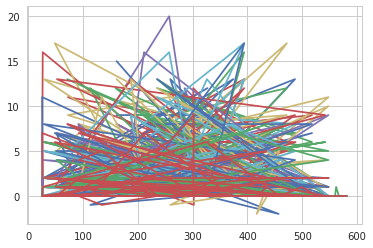

In [114]:
plt.plot(a.iloc[:, 8:29])